In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# --- Settings ---
pd.set_option('display.max_columns', None)

# --- Directories ---
BASE_DIR = os.getcwd()

def build_path(*parts):
    return os.path.join(BASE_DIR, *parts)

FIELD_CONTACT_DIR = os.path.join('..', '..', 'data', 'fieldcontact')
POLICE_REQUESTS_DIR = os.path.join('..', '..', 'data', 'policerequests')
OT_EVENTS_DIR = os.path.join('..', '..', 'data', 'otevents')

# --- Load Data Functions ---
def load_field_contacts():
    files = glob.glob(os.path.join(FIELD_CONTACT_DIR, '*.csv'))
    df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
    return df

def load_police_requests():
    files = glob.glob(os.path.join(POLICE_REQUESTS_DIR, 'Police_Record_Request_*.csv'))
    df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
    return df

def load_ot_events():
    event_files = glob.glob(os.path.join(OT_EVENTS_DIR, '*_otevents.csv'))
    court_files = glob.glob(os.path.join(OT_EVENTS_DIR, '*_courtot.csv'))
    event_df = pd.concat([pd.read_csv(f) for f in event_files], ignore_index=True)
    court_df = pd.concat([pd.read_csv(f) for f in court_files], ignore_index=True)
    return event_df, court_df

# --- 🧹 Preprocessing Functions ---
def preprocess_field_contacts(df):
    df['contact_date'] = pd.to_datetime(df['contact_date'], errors='coerce')
    df['stop_duration'] = df['stop_duration'].fillna(df['stop_duration'].median())
    df['basis'] = df['basis'].fillna('Unknown')
    df['key_situations'] = df['key_situations'].fillna('None')
    df['weather'] = df['weather'].fillna('Unknown')
    return df

def preprocess_ot(df):
    df['OTDATE'] = pd.to_datetime(df['OTDATE'], errors='coerce')
    df['OTHOURS'] = df['OTHOURS'].fillna(0)
    return df

# --- Feature Engineering Functions ---
def feature_engineer_field_contacts(df):
    df['day_of_week'] = df['contact_date'].dt.day_name()
    df['month'] = df['contact_date'].dt.month
    df['year'] = df['contact_date'].dt.year
    
    high_risk_keywords = ['Gun', 'Drugs', 'Gang', 'Shots Fired']
    df['high_risk'] = df['key_situations'].apply(lambda x: any(word in x for word in high_risk_keywords))
    
    return df

def feature_engineer_ot(df):
    df['day_of_week'] = df['OTDATE'].dt.day_name()
    df['month'] = df['OTDATE'].dt.month
    df['year'] = df['OTDATE'].dt.year
    return df

# --- 🚀 Load and Process ---

# Load Data
field_contacts = load_field_contacts()
police_requests = load_police_requests()
otevents, courttot = load_ot_events()

# Preprocess
field_contacts = preprocess_field_contacts(field_contacts)
police_requests = preprocess_ot(police_requests)
otevents = preprocess_ot(otevents)
courttot = preprocess_ot(courttot)

# Feature Engineering
field_contacts = feature_engineer_field_contacts(field_contacts)
notevents = feature_engineer_ot(otevents)
courttot = feature_engineer_ot(courttot)


/var/folders/_r/zj6d9vt949dd8s48h6_3_45m0000gn/T/ipykernel_16639/1221611488.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['OTDATE'] = pd.to_datetime(df['OTDATE'], errors='coerce')
/var/folders/_r/zj6d9vt949dd8s48h6_3_45m0000gn/T/ipykernel_16639/1221611488.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['OTDATE'] = pd.to_datetime(df['OTDATE'], errors='coerce')


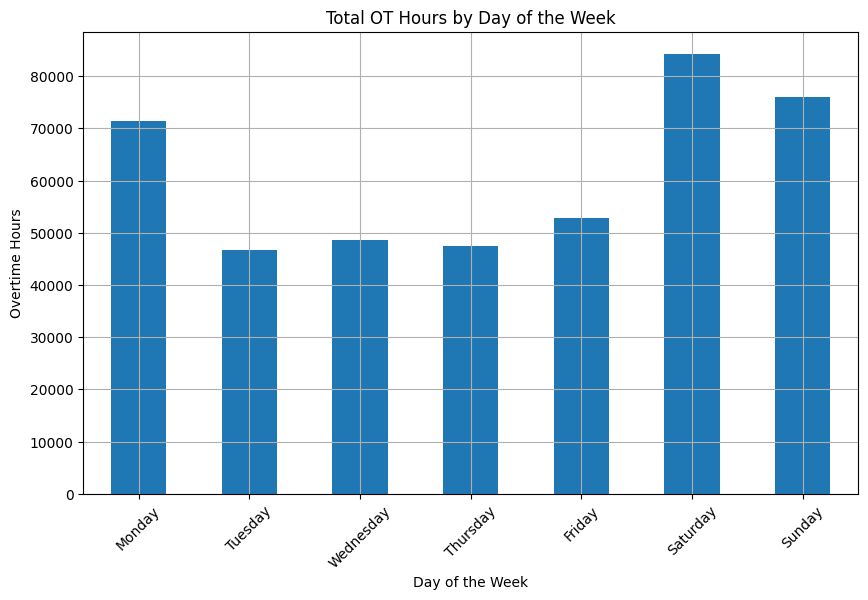

In [3]:
plt.figure(figsize=(10,6))
otevents.groupby('day_of_week')['OTHOURS'].sum().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).plot(kind='bar')
plt.title('Total OT Hours by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Overtime Hours')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


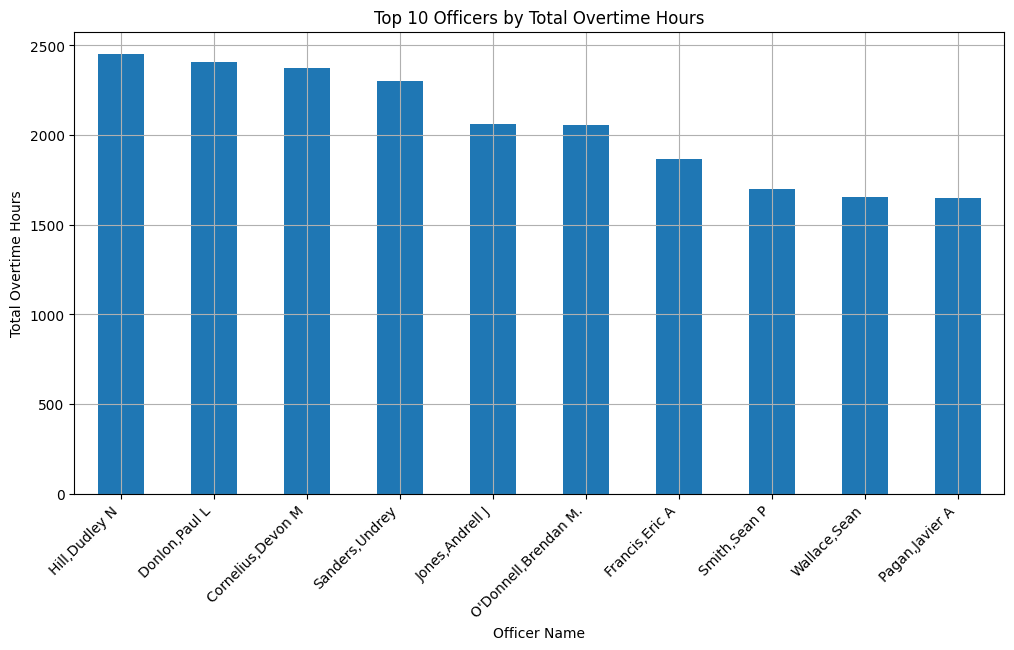

In [4]:
plt.figure(figsize=(12,6))
top_officers = otevents.groupby('NAME')['OTHOURS'].sum().sort_values(ascending=False).head(10)
top_officers.plot(kind='bar')
plt.title('Top 10 Officers by Total Overtime Hours')
plt.xlabel('Officer Name')
plt.ylabel('Total Overtime Hours')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()


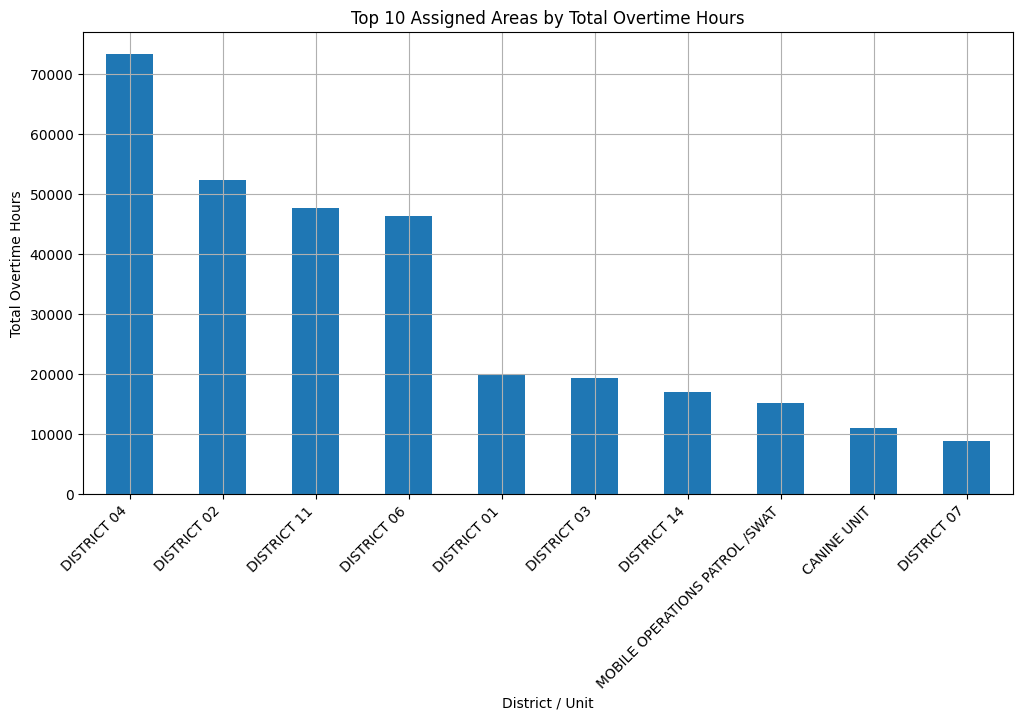

In [6]:
plt.figure(figsize=(12,6))
otevents.groupby('ASSIGNED_DESC')['OTHOURS'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Assigned Areas by Total Overtime Hours')
plt.xlabel('District / Unit')
plt.ylabel('Total Overtime Hours')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()


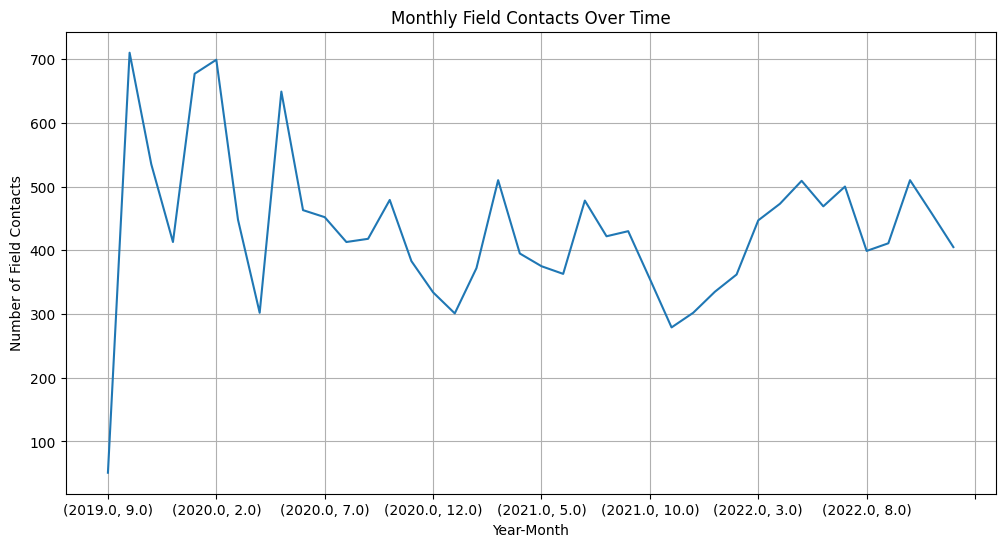

In [7]:
plt.figure(figsize=(12,6))
field_contacts.groupby(['year', 'month']).size().plot()
plt.title('Monthly Field Contacts Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Field Contacts')
plt.grid(True)
plt.show()


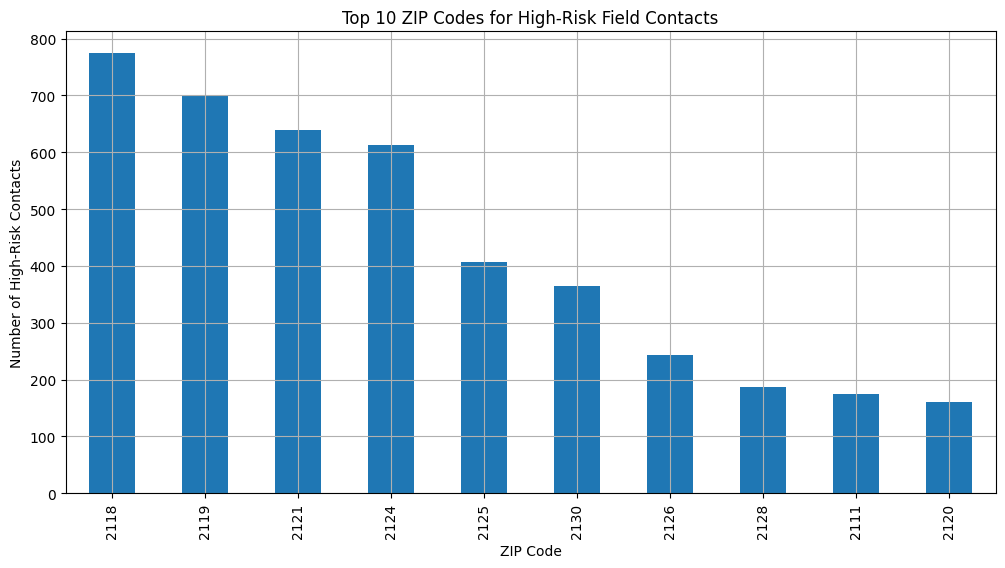

In [8]:
high_risk_contacts = field_contacts[field_contacts['high_risk'] == True]

plt.figure(figsize=(12,6))
high_risk_contacts['zip'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 ZIP Codes for High-Risk Field Contacts')
plt.xlabel('ZIP Code')
plt.ylabel('Number of High-Risk Contacts')
plt.grid(True)
plt.show()


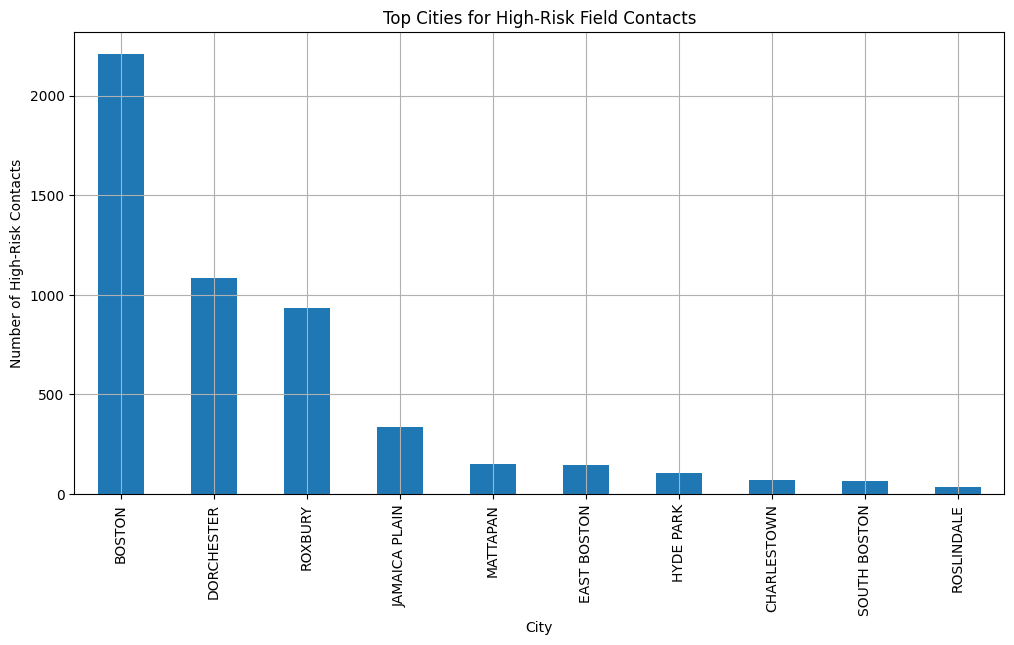

In [9]:
high_risk_contacts = field_contacts[field_contacts['high_risk'] == True]

plt.figure(figsize=(12,6))
high_risk_contacts['city'].value_counts().head(10).plot(kind='bar')
plt.title('Top Cities for High-Risk Field Contacts')
plt.xlabel('City')
plt.ylabel('Number of High-Risk Contacts')
plt.grid(True)
plt.show()

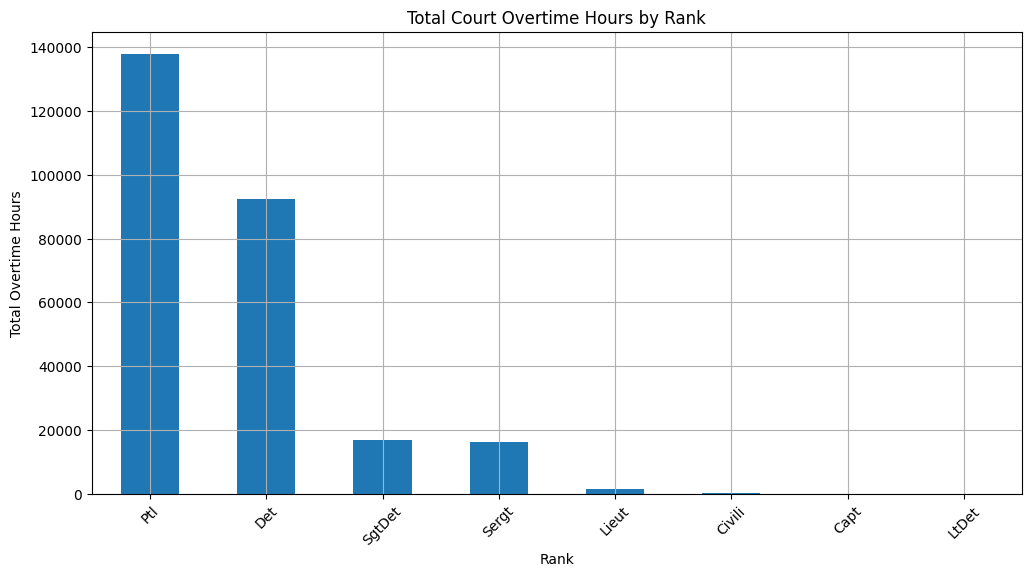

In [10]:
plt.figure(figsize=(12,6))
courttot.groupby('RANK')['OTHOURS'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Total Court Overtime Hours by Rank')
plt.xlabel('Rank')
plt.ylabel('Total Overtime Hours')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


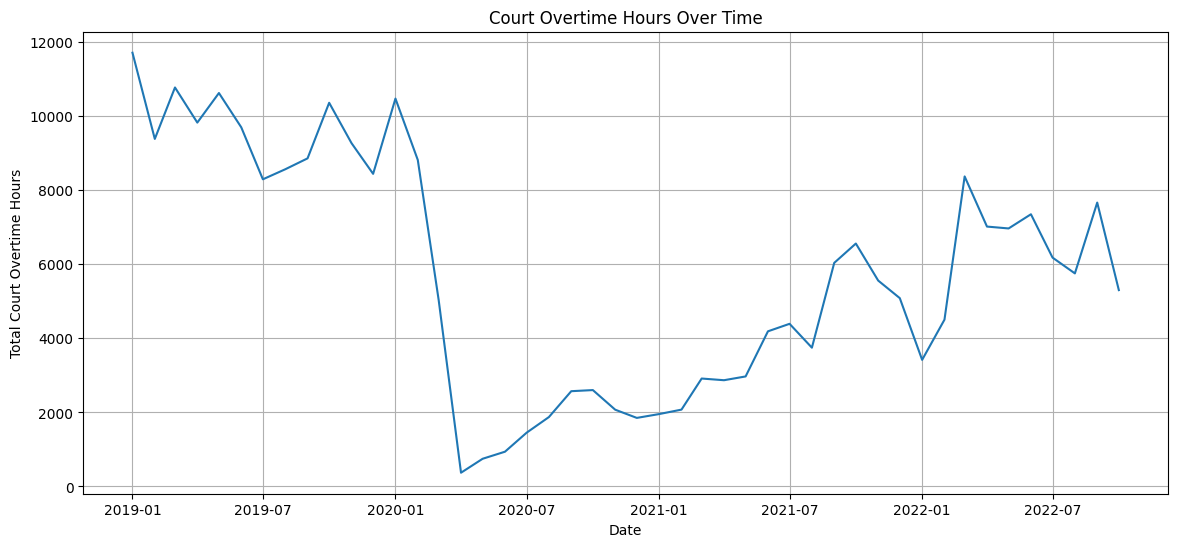

In [11]:
courttot['month'] = courttot['OTDATE'].dt.month
courttot['year'] = courttot['OTDATE'].dt.year

monthly_court_ot = courttot.groupby(['year', 'month'])['OTHOURS'].sum().reset_index()
monthly_court_ot['date'] = pd.to_datetime(dict(year=monthly_court_ot.year, month=monthly_court_ot.month, day=1))
monthly_court_ot = monthly_court_ot.sort_values('date')

plt.figure(figsize=(14,6))
plt.plot(monthly_court_ot['date'], monthly_court_ot['OTHOURS'])
plt.title('Court Overtime Hours Over Time')
plt.xlabel('Date')
plt.ylabel('Total Court Overtime Hours')
plt.grid(True)
plt.show()


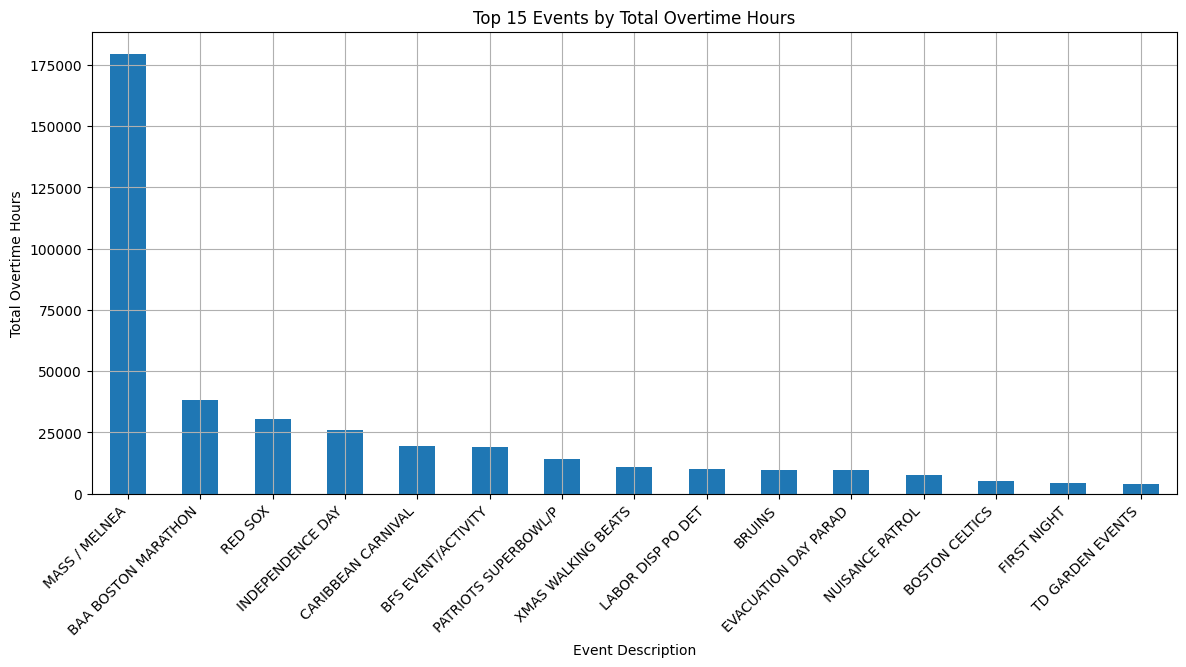

In [12]:
plt.figure(figsize=(14,6))
otevents.groupby('DESCRIPTION')['OTHOURS'].sum().sort_values(ascending=False).head(15).plot(kind='bar')
plt.title('Top 15 Events by Total Overtime Hours')
plt.xlabel('Event Description')
plt.ylabel('Total Overtime Hours')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()


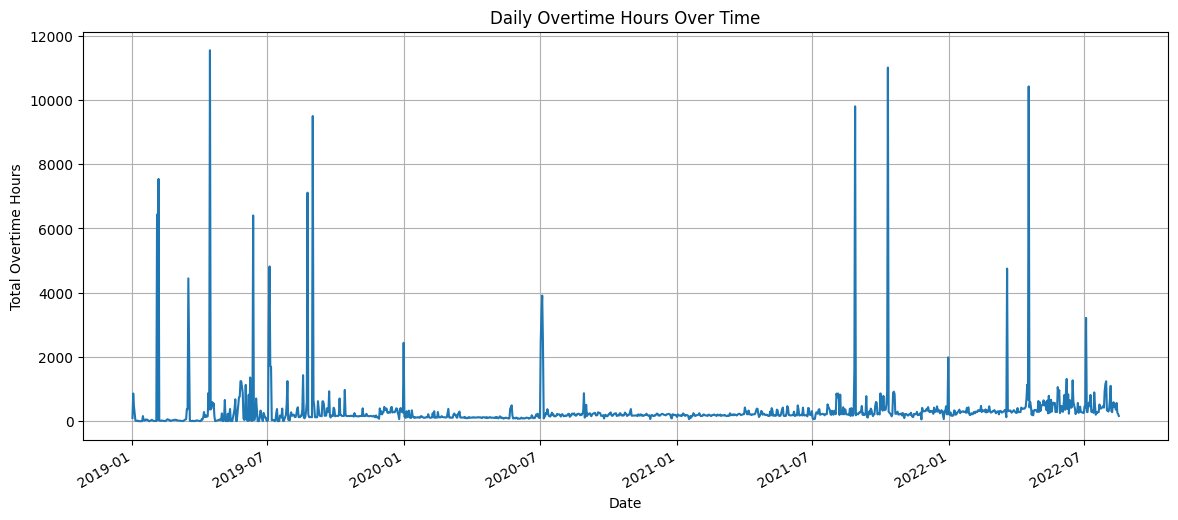

In [13]:
plt.figure(figsize=(14,6))
otevents.groupby('OTDATE')['OTHOURS'].sum().plot()
plt.title('Daily Overtime Hours Over Time')
plt.xlabel('Date')
plt.ylabel('Total Overtime Hours')
plt.grid(True)
plt.show()


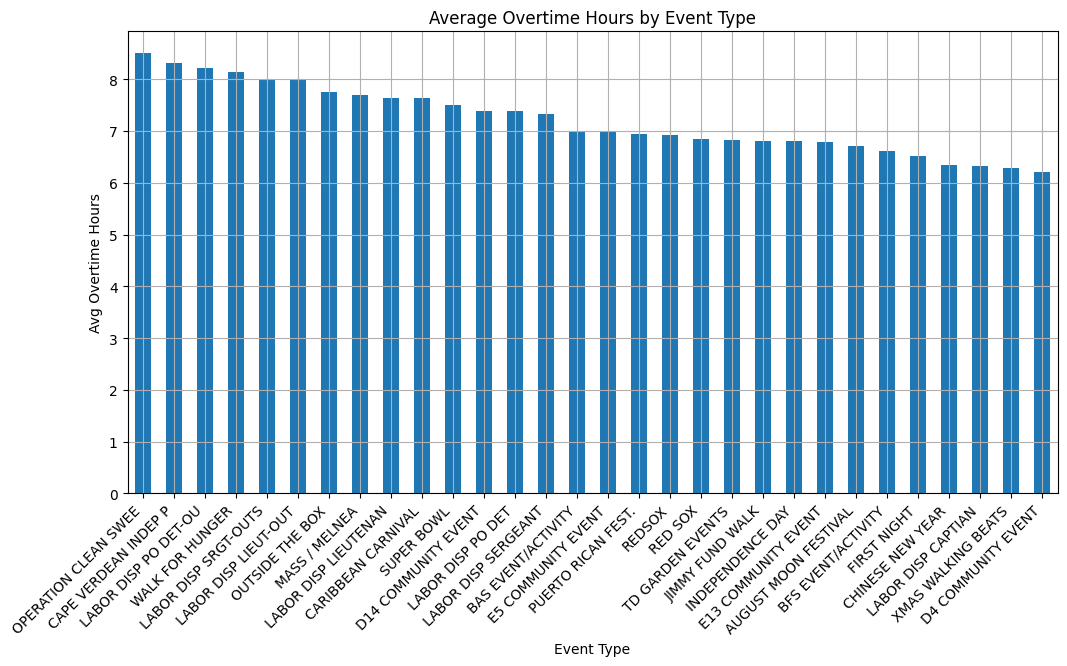

In [14]:
event_hours = otevents.groupby('DESCRIPTION')['OTHOURS'].mean().sort_values(ascending=False).head(30)

plt.figure(figsize=(12,6))
event_hours.plot(kind='bar')
plt.title('Average Overtime Hours by Event Type')
plt.xlabel('Event Type')
plt.ylabel('Avg Overtime Hours')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()


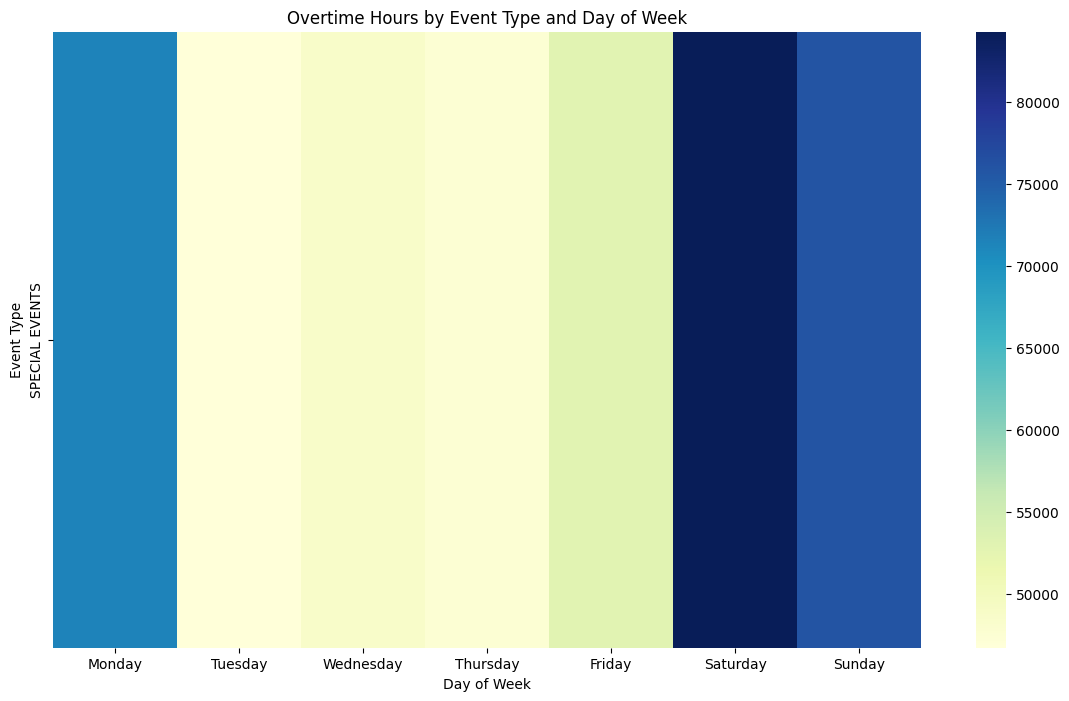

In [15]:
event_type_weekday = otevents.groupby(['DESCRIPTIONS', 'day_of_week'])['OTHOURS'].sum().reset_index()

pivot_table = event_type_weekday.pivot(index='DESCRIPTIONS', columns='day_of_week', values='OTHOURS').fillna(0)

pivot_table = pivot_table[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]  # reorder days

plt.figure(figsize=(14,8))
sns.heatmap(pivot_table, cmap='YlGnBu')
plt.title('Overtime Hours by Event Type and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Event Type')
plt.show()

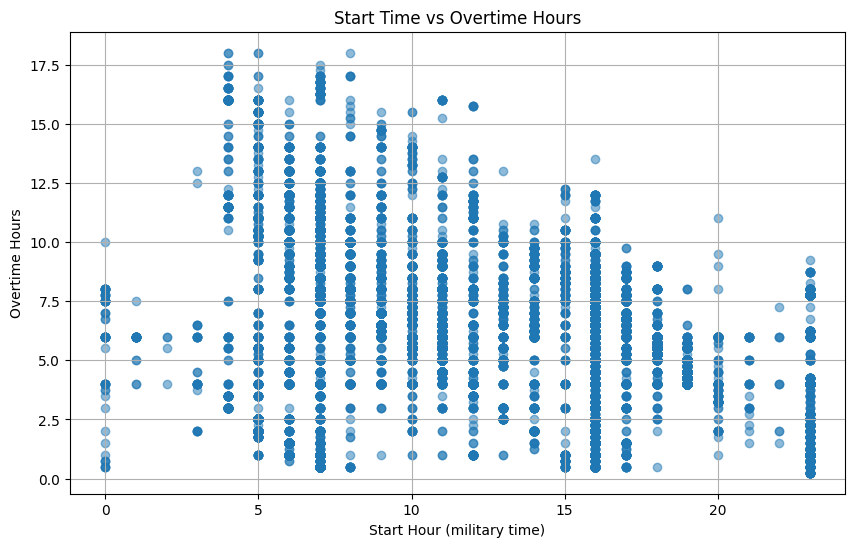

In [16]:
def parse_time(x):
    try:
        return int(x)
    except:
        return np.nan

otevents['START_HOUR'] = otevents['STARTTIME'].apply(parse_time) // 100

plt.figure(figsize=(10,6))
plt.scatter(otevents['START_HOUR'], otevents['OTHOURS'], alpha=0.5)
plt.title('Start Time vs Overtime Hours')
plt.xlabel('Start Hour (military time)')
plt.ylabel('Overtime Hours')
plt.grid(True)
plt.show()


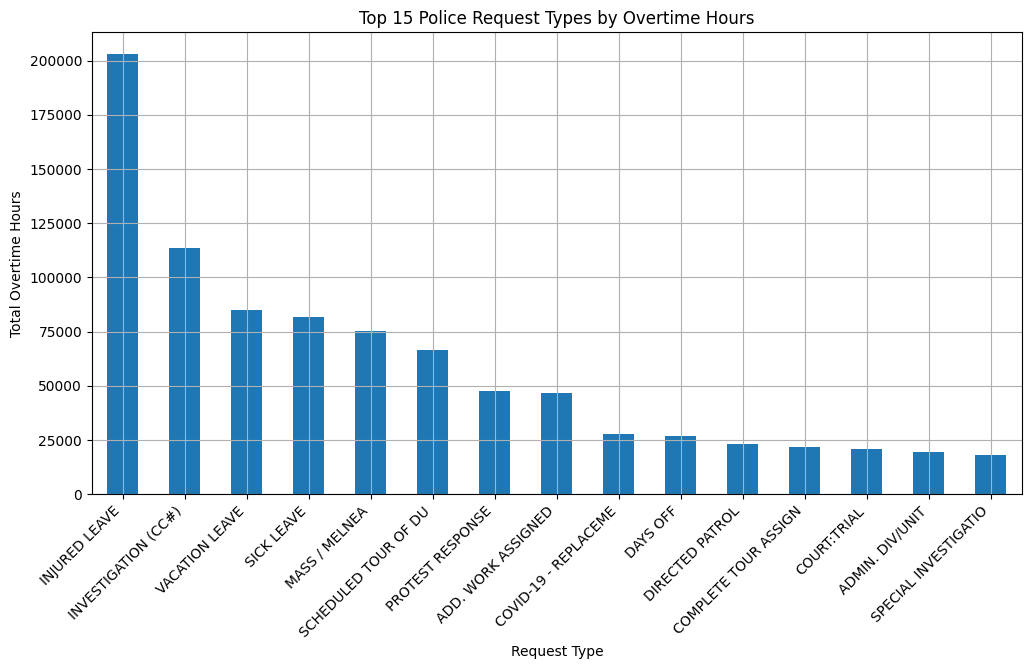

In [17]:
plt.figure(figsize=(12,6))
police_requests.groupby('DESCRIPTION')['OTHOURS'].sum().sort_values(ascending=False).head(15).plot(kind='bar')
plt.title('Top 15 Police Request Types by Overtime Hours')
plt.xlabel('Request Type')
plt.ylabel('Total Overtime Hours')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()


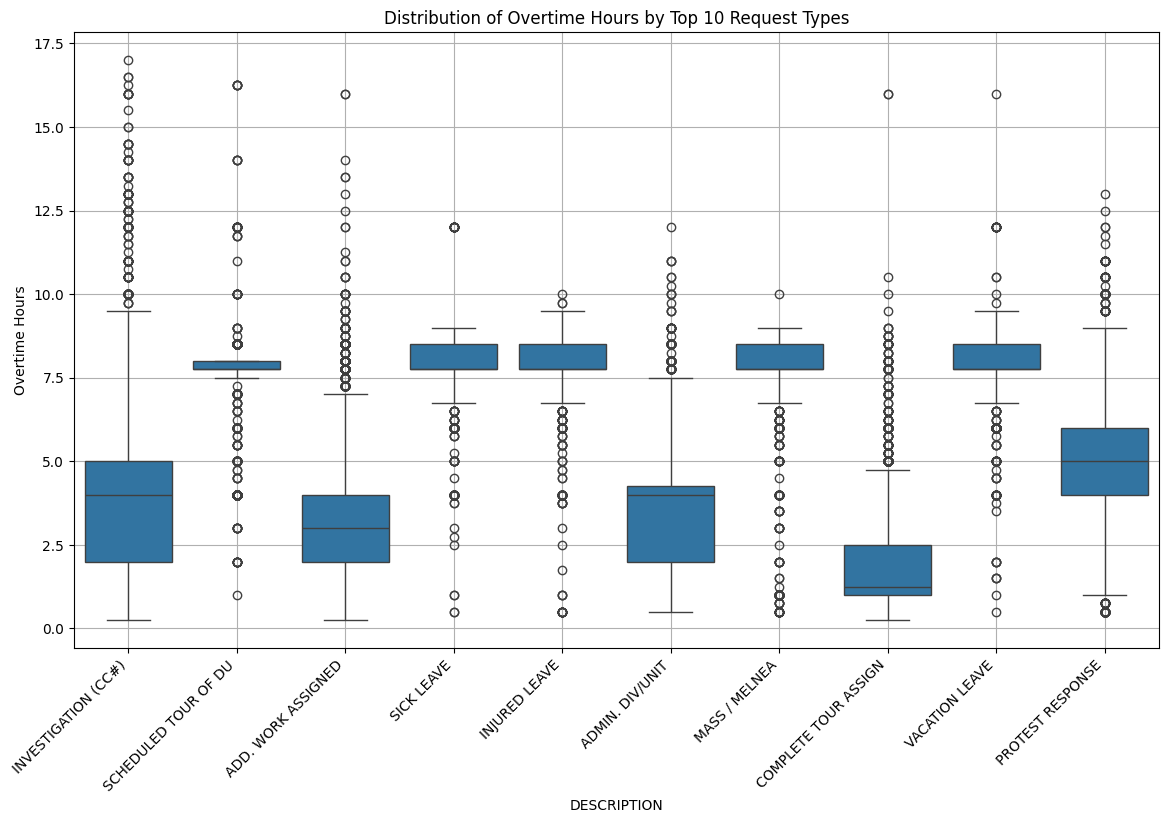

In [24]:
plt.figure(figsize=(14,8))
top_request_types = police_requests['DESCRIPTION'].value_counts().head(10).index
subset = police_requests[police_requests['DESCRIPTION'].isin(top_request_types)]

sns.boxplot(data=subset, x='DESCRIPTION', y='OTHOURS')
plt.title('Distribution of Overtime Hours by Top 10 Request Types')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Overtime Hours')
plt.grid(True)
plt.show()


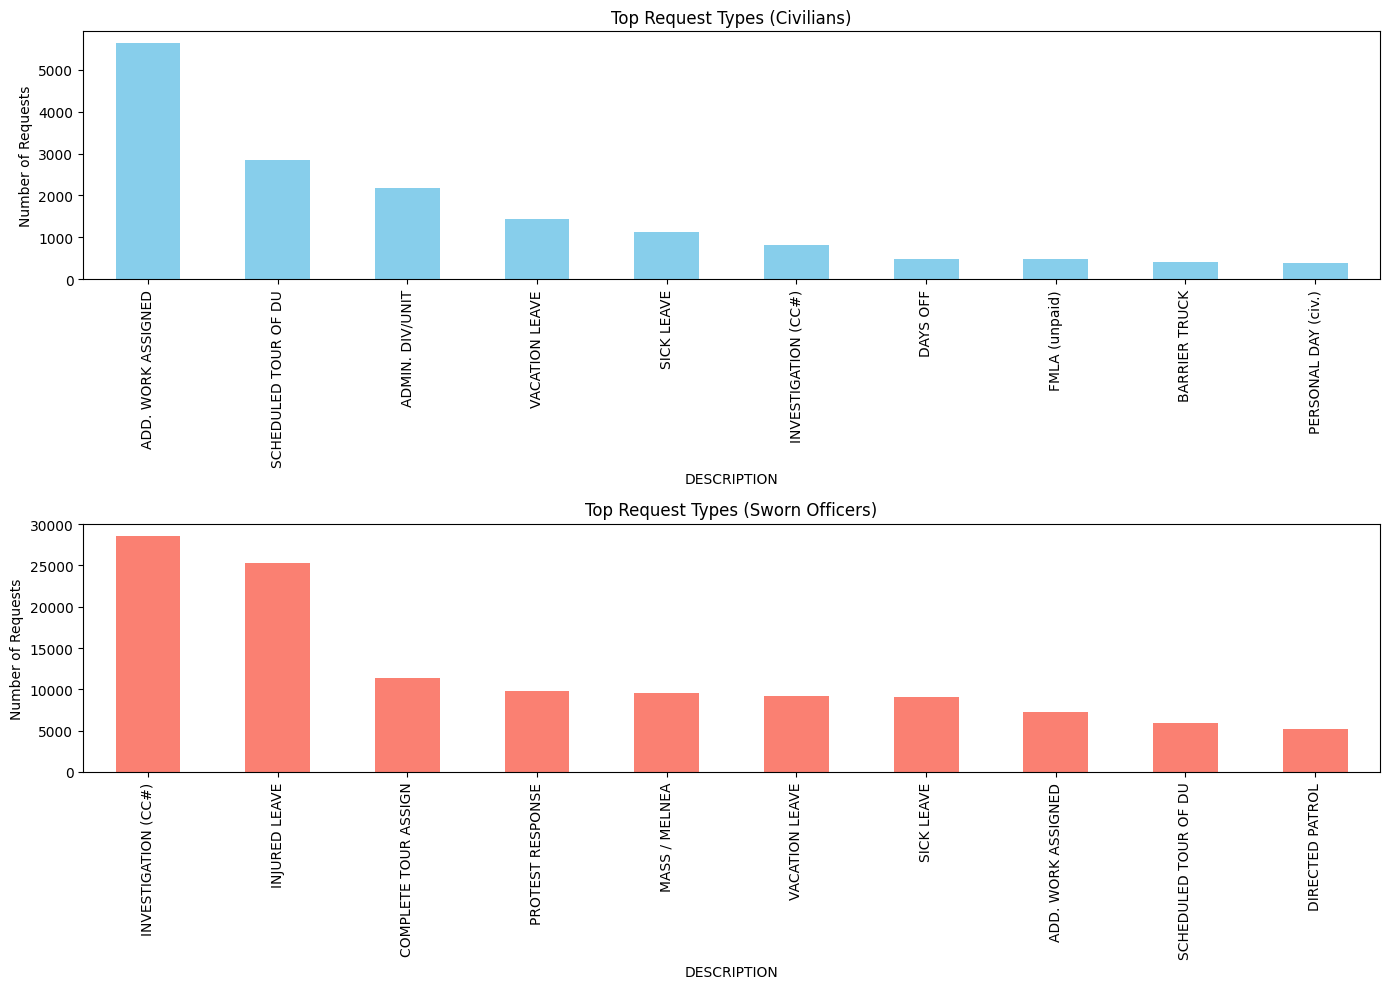

In [23]:
police_requests['is_civilian'] = police_requests['RANK'].str.strip().str.lower().str.startswith('civili')

# Now your plotting code works!
civilian_types = police_requests[police_requests['is_civilian'] == True]['DESCRIPTION'].value_counts().head(10)
officer_types = police_requests[police_requests['is_civilian'] == False]['DESCRIPTION'].value_counts().head(10)

fig, axes = plt.subplots(2, 1, figsize=(14,10))
civilian_types.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Top Request Types (Civilians)')
axes[0].set_ylabel('Number of Requests')

officer_types.plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Top Request Types (Sworn Officers)')
axes[1].set_ylabel('Number of Requests')

plt.tight_layout()
plt.show()


Probable Cause           9705
Reasonable Suspicion     7558
Encounter                5162
Intel                    5104
Reasonable Suspicion      436
Unknown                    49
Name: basis, dtype: int64


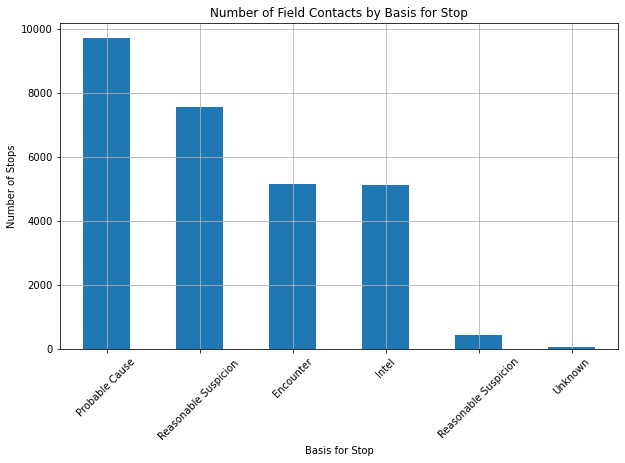

In [ ]:
# Clean basis column just in case
field_contacts['basis'] = field_contacts['basis'].fillna('Unknown')

# Count how many stops per basis
basis_counts = field_contacts['basis'].value_counts()

# Print first few just to inspect
print(basis_counts)

plt.figure(figsize=(10,6))
basis_counts.plot(kind='bar')
plt.title('Number of Field Contacts by Basis for Stop')
plt.xlabel('Basis for Stop')
plt.ylabel('Number of Stops')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
